# Libraries and data importing

Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

Importing data

In [5]:
activities = pd.read_parquet('../data-raw/activities.parquet')
activities

,contributor,category,repository,activity,date
0,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:19+00:00
1,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:23+00:00
2,AmplabJenkins,bot,apache/spark,Commenting pull request,2022-11-25 09:55:26+00:00
3,analysis-bot,bot,facebook/react-native,Commenting pull request,2022-11-25 09:55:27+00:00
4,neos-bot,bot,neos/neos-ui-compiled,Pushing commits,2022-11-25 09:55:47+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


600 events at max for each contributor

In [6]:
data = ( 
    activities
    # keep the last 600 events for each contributor
    .groupby('contributor')
    .tail(600)
    # keep the contributors who have more than 600 events
    .groupby('contributor')
    .filter(lambda x: len(x) == 600)
)
data

,contributor,category,repository,activity,date
365,nodebb-misty,bot,julianlam/nodebb-plugin-email-helper,Closing pull request,2022-11-25 11:08:46+00:00
409,nodebb-misty,bot,NodeBB/nodebb-plugin-topic-redirect,Closing pull request,2022-11-25 11:20:10+00:00
417,nodebb-misty,bot,NodeBB/nodebb-plugin-write-api,Closing pull request,2022-11-25 11:21:23+00:00
523,nodebb-misty,bot,julianlam/nodebb-plugin-sso-oauth,Closing pull request,2022-11-25 11:47:30+00:00
5518,jenkins-x-bot-test,bot,jenkins-x-charts/jxboot-helmfile-resources,Creating branch,2022-11-26 19:57:10+00:00
...,...,...,...,...,...
1015418,798388,human,879434,Reviewing code,2023-04-15 16:06:15+00:00
1015419,798388,human,879434,Reviewing code,2023-04-15 16:07:26+00:00
1015420,784775,human,643744,Creating branch,2023-04-15 16:07:33+00:00
1015421,784775,human,888378,Opening pull request,2023-04-15 16:08:07+00:00


In [7]:
def gap_activities(train, test):

    start_time = train['date'].iloc[-1] + pd.Timedelta(hours=1)
    end_time = test['date'].iloc[0] - pd.Timedelta(hours=1)

    #  check if there is a time gap between the train and test data
    if end_time - start_time >= pd.Timedelta(hours=0):

        # fill the gap with a date range and zeros for n_activities
        gap_data = pd.DataFrame({
            'category': train['category'].iloc[0],
            'date': pd.date_range(start=start_time, end=end_time, freq='H'),
            'contributor': train['contributor'].iloc[0],
            'n_activities': 0
        })

        test = pd.concat([gap_data, test]).reset_index(drop=True)
    
    return test

In [8]:
def split_activities(contributor):

    # spliting the data into training and testing sets for time series forecasting, using a time-based split with split size = 0.5
    train, test = (
        contributor
        .apply(lambda x: x[:300]) # head(300)
        .groupby(['category', pd.Grouper(key='date', freq='H'), 'contributor'])['activity']
        .count()
        .reset_index(name='n_activities'),

        contributor
        .apply(lambda x: x[300:])
        .groupby(['category', pd.Grouper(key='date', freq='H'), 'contributor'])['activity']
        .count()
        .reset_index(name='n_activities')
    )

    # checking if the last timestamp of the train data is equal to the first timestamp of the second data
    if train['date'].iloc[-1] == test['date'].iloc[0]:
        # adding the value of the last time value (n_activities) of train data to the value of the first time (n_activities) of the test data
        test.loc[0, 'n_activities'] += train.loc[train.index[-1], 'n_activities']
        # removing the last time of the train data
        train.drop(train.index[-1], inplace=True)

    test = gap_activities(train, test)

    # filling n_activities with zeros for the empty hours between the minimum and maximum date
    train, test = (
        # for train set, we take last 3 months
        train[train['date'] >= train['date'].max() - pd.DateOffset(months=3)]
        .set_index('date')
        .resample('H')
        .sum()
        .rename_axis(None)
        .replace({'category': 0, 'contributor': 0}, None)
        .ffill(),
        
        test
        .set_index('date')
        .resample('H')
        .sum()
        .rename_axis(None)
        .replace({'category': 0, 'contributor': 0}, None)
        .ffill()
    )

    train.index.freq = 'H'

    return train, test

# New evaluation metrics PGA & CTD?

A new evaluation metric that calculates the percentage of predicted values greater than or equal to the actual values. We can define this metric as follows:

$$PGA = \frac{\sum_{i=1}^{n} [y_i \leq \hat{y}_i]}{n}$$

In [9]:
def pga_score(y_true, y_pred):
    return (y_pred >= y_true).mean()

A novel evaluation metric designed to quantify the time difference between the cumulative sums of true and predicted values in reaching a specified target value.

$$ \text{CTD} = \text{argmax}(C_t \geq T) - \text{argmax}(C_p \geq T) $$

This formula represents the time difference between the cumulative sums of the true $C_t$ and predicted $C_p$ values in reaching a specified target value $T(100, 200, 300)$, where ${argmax}$ returns the time of the first occurrence where the condition is satisfied.

In [20]:
def ctd_score(y_true, y_pred, target_value):

    coef = 1
    if (sum(y_true) < target_value) | (sum(y_pred) < target_value):
        coef = -1

    true_cumsum, pred_cumsum = np.cumsum(y_true), np.cumsum(y_pred)
    time_true, time_pred = np.argmax(true_cumsum >= target_value), np.argmax(pred_cumsum >= target_value)

    display(true_cumsum.tolist(), pred_cumsum.tolist())

    return coef*(time_true - time_pred)

In [ ]:
true_values = [2, 11, 84, 57, 0, 38, 15, 80, 4, 30, 90, 0, 0, 0]
pred_values = [52, 22, 95, 9, 11, 1, 73, 0, 30, 50, 100, 70, 50, 500]


print("Cumulative Time Difference:", ctd_score(true_values, pred_values, 400))

# 1. Autoregressive model

In [ ]:
def ar_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets
    train, test = split_activities(contributor)

    # Fit the model
    try: #calculate parameter based on time range
        lags = [1, 12, 24, 168]
        model = AutoReg(train['n_activities'], lags=lags).fit()
        predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)
    except IndexError:
        lags = [1, 12, 24]
        model = AutoReg(train['n_activities'], lags=lags).fit()
        predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)
    except: # eviter
        lags = int(len(train)/2)-1
        model = AutoReg(train['n_activities'], lags=lags).fit()
        predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'lags': lags,
        'true_values': test['n_activities'].values,
        'predicted_values': predictions['mean'].values,
    })

    return metrics

In [ ]:
# Apply the function to each contributor
ar_results = data.groupby(['category', 'contributor']).apply(ar_model).reset_index(drop=True)

In [ ]:
ar_results.head()

In [ ]:
ar_results.to_csv('../models-evaluation-v2/ar_model_metrics.csv', index=False)

# 2. Seasonal Autoregressive integrated Moving-average model

In [36]:
def sarima_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets
    train, test = split_activities(contributor)

    # Fit the model
    model = SARIMAX(train['n_activities'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24), enforce_invertibility=False, enforce_stationarity=False).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'true_values': test['n_activities'].values,
        'predicted_values': predictions['mean'].values,
    })

    return metrics

In [ ]:
# Apply the function to each contributor
sarima_results = data.groupby(['category', 'contributor']).apply(sarima_model).reset_index(drop=True)

In [ ]:
sarima_results.head()

In [54]:
sarima_results['ctd_200'].describe()

count     270.000000
mean       43.333333
std       376.655779
min     -1583.000000
25%       -87.000000
50%        49.500000
75%       195.000000
max      1654.000000
Name: ctd_200, dtype: float64

In [38]:
sarima_results.to_csv('../models-evaluation-v2/sarima_model_metrics.csv', index=False)

# 3. Unobserved components model

In [50]:
def uc_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets
    train, test = split_activities(contributor)

    # Fit the model
    model = UnobservedComponents(train['n_activities'], level=True, seasonal=24).fit(disp=False, method='lbfgs')

    # Forecast the test set using confidence interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'true_values': test['n_activities'].values,
        'predicted_values': predictions['mean'].values,
    })

    return metrics

In [ ]:
# Apply the function to each contributor
uc_results = data.groupby(['category', 'contributor']).apply(uc_model).reset_index(drop=True)

In [58]:
uc_results.head()

,contributor,category,r2,mae,rmse,pga,ctd_100,ctd_200,ctd_300,n_activities,true_values,predicted_values
0,0crat,bot,-28.182813,1.763689,4.623033,0.522871,-27,554,2160,299,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-10.865246652203826, -2.9976021664879227e-14,..."
1,AppVeyorBot,bot,-1.805298,0.920885,1.360526,0.491228,14,43,35,300,"[2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 1, ...","[-2.6626971540656217, 0.9999999999999801, -2.1..."
2,Code-Inside-Bot,bot,0.997575,0.010261,0.106486,0.488782,0,0,0,293,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.053956836175795664, 8.326672684688674e-16,..."
3,CrowdinBot,bot,-11.708097,5.590824,16.525215,0.512605,167,-140,-475,292,"[0, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-61.661606635544615, 1.2656542480726785e-14, ..."
4,DrahtBot,bot,-2.397859,0.869927,1.678403,0.504310,6,20,16,299,"[0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, ...","[-5.0844076127571, 3.552713678800501e-15, 0.99..."


In [66]:
uc_results[['contributor', 'category', 'r2', 'rmse', 'pga', 'ctd_100', 'ctd_200', 'ctd_300']].sample(10)

,contributor,category,r2,rmse,pga,ctd_100,ctd_200,ctd_300
41,dotnet-issue-labeler[bot],bot,-6.076491,1.785611,0.605005,-99,-70,103
79,linux-foundation-easycla[bot],bot,-3.789382,2.854983,0.676856,49,31,24
129,softwarefactory-project-zuul[bot],bot,-1.272543,3.353500,0.635135,66,67,72
203,646795,human,-14.792090,3.885449,0.676838,3,199,946
117,restyled-io[bot],bot,-47.873018,23.191936,0.893443,24,53,100
122,rustbot,bot,-1.322096,2.480009,0.517073,-9,-27,-204
86,minio-trusted,bot,-2.047798,1.386977,0.706714,63,173,628
247,885533,human,-11.837889,6.338821,0.519126,-54,-36,228
260,966834,human,-0.159888,1.745436,0.477044,-69,-244,-892
125,scrutinizer-notifier,bot,-1.871555,2.747690,0.611111,-55,-31,52


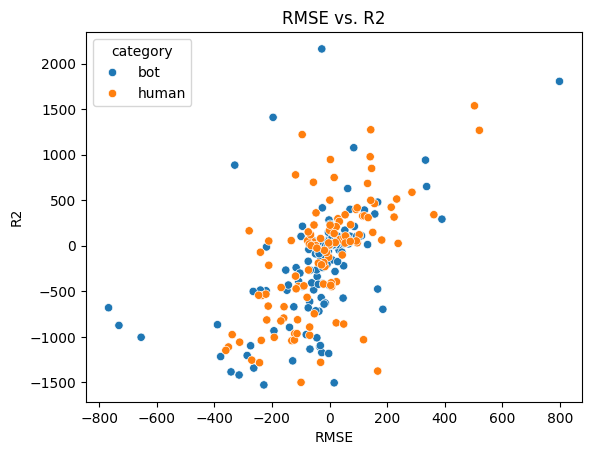

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot
sns.scatterplot(data=uc_results, x='ctd_100', y='ctd_300', hue='category')
plt.xlabel('RMSE')
plt.ylabel('R2')
plt.title('RMSE vs. R2')
plt.show()

In [82]:
uc_results['ctd_100'].describe()

count    270.000000
mean     -26.574074
std      160.210665
min     -767.000000
25%      -75.500000
50%      -11.000000
75%       33.750000
max      798.000000
Name: ctd_100, dtype: float64

In [52]:
uc_results.to_csv('../models-evaluation-v2/uc_model_metrics.csv', index=False)

# 4. Holt-Winters (triple) exponential smoothing model

In [84]:
def tes_model(contributor):

    print(contributor['contributor'].iloc[0])

    # Spliting the data into training and testing sets
    train, test = split_activities(contributor)

    # Fit the model
    try:
        model = ETSModel(train['n_activities'], error='add', trend='add', seasonal='add', seasonal_periods=24).fit(disp=False)
    except ValueError:
        model = ETSModel(train['n_activities'], error='add', trend='add').fit(disp=False)
    except:
        print("Something else went wrong")

    # Forecast the test set using prediction interval with 95%
    predictions = model.get_prediction(start=len(train), end=len(train)+len(test)-1).summary_frame(alpha=0.05)

    # Create a series for evaluation metrics and sum of activities
    metrics = pd.Series({
        'contributor': contributor['contributor'].iloc[0],
        'category': contributor['category'].iloc[0],
        'r2': r2_score(test['n_activities'], predictions['mean']),
        'mae': mean_absolute_error(test['n_activities'], predictions['mean']),
        'rmse': root_mean_squared_error(test['n_activities'], predictions['mean']),
        'pga': pga_score(test['n_activities'], predictions['mean']),
        'ctd_100': ctd_score(test['n_activities'], predictions['mean'], 100),
        'ctd_200': ctd_score(test['n_activities'], predictions['mean'], 200),
        'ctd_300': ctd_score(test['n_activities'], predictions['mean'], 300),
        'n_activities': train['n_activities'].sum(),
        'true_values': test['n_activities'].values,
        'predicted_values': predictions['mean'].values,
    })

    return metrics

In [ ]:
# Apply the function to each contributor
tes_results = data.groupby(['category', 'contributor']).apply(tes_model).reset_index(drop=True)

In [ ]:
tes_results.head()

In [94]:
tes_results['ctd_100'].describe()

count     270.000000
mean        0.951852
std       210.561229
min     -1035.000000
25%       -57.000000
50%         5.000000
75%       107.000000
max       607.000000
Name: ctd_100, dtype: float64

In [90]:
tes_results.to_csv('../models-evaluation-v2/tes_model_metrics.csv', index=False)

# Models comparing

In [25]:
ar_results = pd.read_csv('../models-evaluation-v2/ar_model_metrics.csv')
sarima_results = pd.read_csv('../models-evaluation-v2/sarima_model_metrics.csv')
uc_results = pd.read_csv('../models-evaluation-v2/uc_model_metrics.csv')
tes_results = pd.read_csv('../models-evaluation-v2/tes_model_metrics.csv')

In [26]:
ar_results['model'] = 'ar'
sarima_results['model'] = 'sarima'
uc_results['model'] = 'uc'
tes_results['model'] = 'tes'

In [27]:
ar_results.drop('lags', axis=1, inplace=True)

In [28]:
results = pd.concat([ar_results, sarima_results, uc_results, tes_results], ignore_index=True)
results.drop(['n_activities', 'true_values', 'predicted_values'], axis=1, inplace=True)

results['ctd_100_abs'] = results['ctd_100'].abs()
results['ctd_200_abs'] = results['ctd_200'].abs()
results['ctd_300_abs'] = results['ctd_300'].abs()

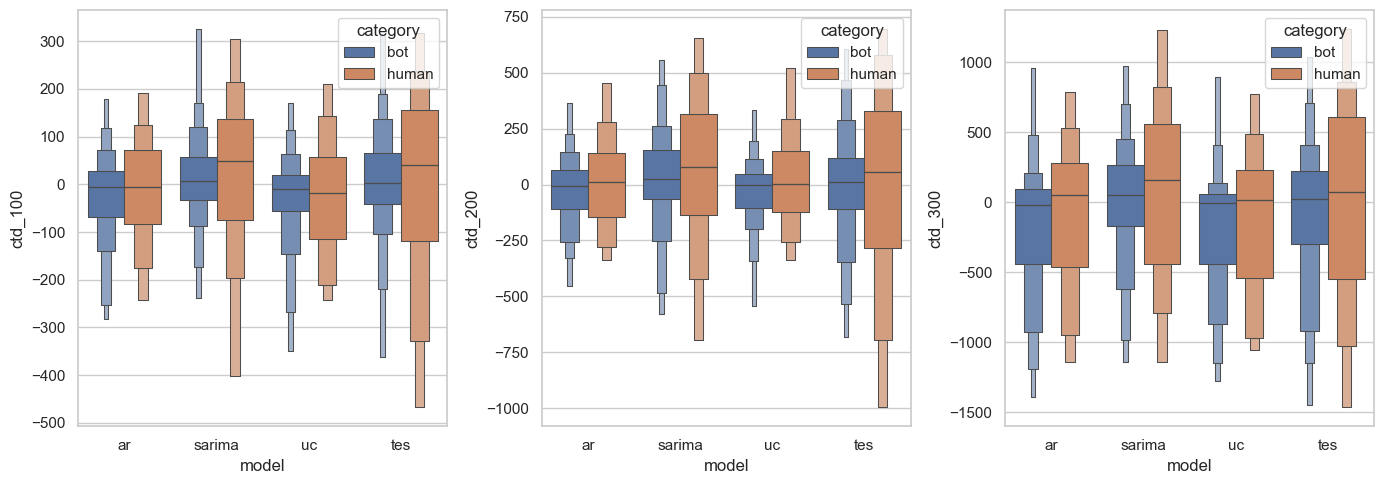

In [29]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.boxenplot(data=results, x='model', y='ctd_100', hue='category', ax=axes[0], showfliers=False)
sns.boxenplot(data=results, x='model', y='ctd_200', hue='category', ax=axes[1], showfliers=False)
sns.boxenplot(data=results, x='model', y='ctd_300', hue='category', ax=axes[2], showfliers=False)

plt.tight_layout()
plt.show()

In [36]:
sarima_results

,contributor,category,r2,mae,rmse,pga,ctd_100,ctd_200,ctd_300,n_activities,true_values,predicted_values,model
0,0crat,bot,-16.604704,3.215548,3.590689,0.977918,18,655,2317,299,[5 0 0 ... 0 0 2],[1.99969781 0.80074883 1.87742101 ... 5.477359...,sarima
1,AppVeyorBot,bot,-0.078029,0.685009,0.843398,0.649123,33,89,107,300,[2 0 0 0 0 1 0 0 0 0 1 0 1 2 1 0 0 0 0 0 0 0 1...,[0.78275963 0.98514054 0.81382963 0.91798948 0...,sarima
2,Code-Inside-Bot,bot,0.997596,0.015858,0.106027,0.967949,0,0,24,293,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[2.97413909e-03 2.97649233e-03 2.97649419e-03 ...,sarima
3,CrowdinBot,bot,-0.333277,3.689869,5.352629,0.981092,71,47,340,292,[ 0 30 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.44004943 1.62136606 1.50936518 1.51866752 1...,sarima
4,DrahtBot,bot,-0.015521,0.485131,0.917567,0.687500,36,41,-927,299,[0 0 7 0 0 0 0 0 0 0 1 2 1 0 0 1 1 0 0 0 0 0 0...,[ 3.90496547e-01 3.46979921e-01 3.18309325e-...,sarima
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,983548,human,0.335604,0.519367,1.492165,0.583691,-189,-263,-458,296,[ 5 1 6 0 0 0 0 0 0 0 0 3 0 0 0 ...,[ 3.97572204e-01 7.55693899e-02 5.70226873e+...,sarima
266,983874,human,-0.525482,2.110249,2.492792,0.887255,146,204,222,297,[ 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[0.99857859 1.44088007 1.00649792 2.23440697 1...,sarima
267,985588,human,-0.440364,1.099473,1.782015,0.354108,24,-425,-705,300,[ 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 3.64753401e+00 1.18732175e+00 -7.72712263e-...,sarima
268,987894,human,-0.011851,0.935928,2.476193,0.403670,-172,-289,-434,296,[ 0 5 32 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1.50973523e-01 5.21835836e-01 1.31898042e+...,sarima


<Axes: xlabel='ctd_300', ylabel='nh'>

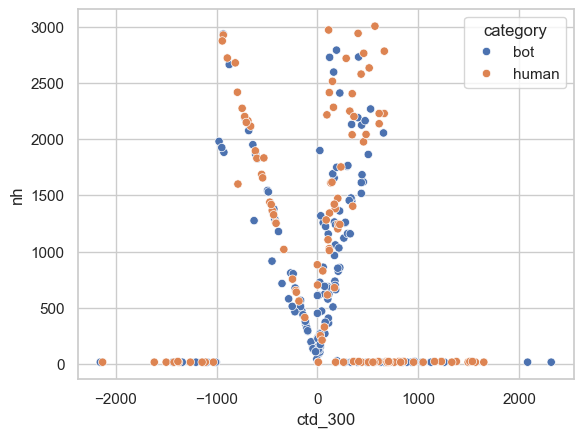

In [39]:
sns.scatterplot(data=sarima_results.assign(nh=lambda d: d.true_values.apply(len)), x='ctd_300', y='nh', hue='category')

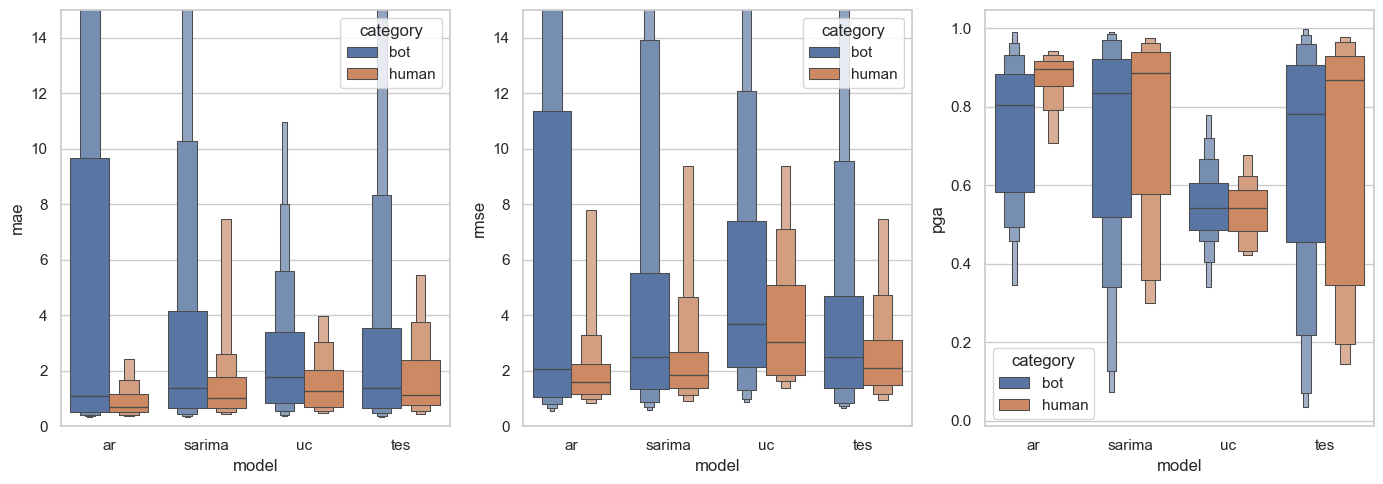

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.boxenplot(data=results, x='model', y='mae', hue='category', ax=axes[0], showfliers=False)
sns.boxenplot(data=results, x='model', y='rmse', hue='category', ax=axes[1], showfliers=False)
sns.boxenplot(data=results, x='model', y='pga', hue='category', ax=axes[2], showfliers=False)

axes[0].set_ylim(0, 15)
axes[1].set_ylim(0, 15)

plt.tight_layout()
plt.show()

# Activitiy types

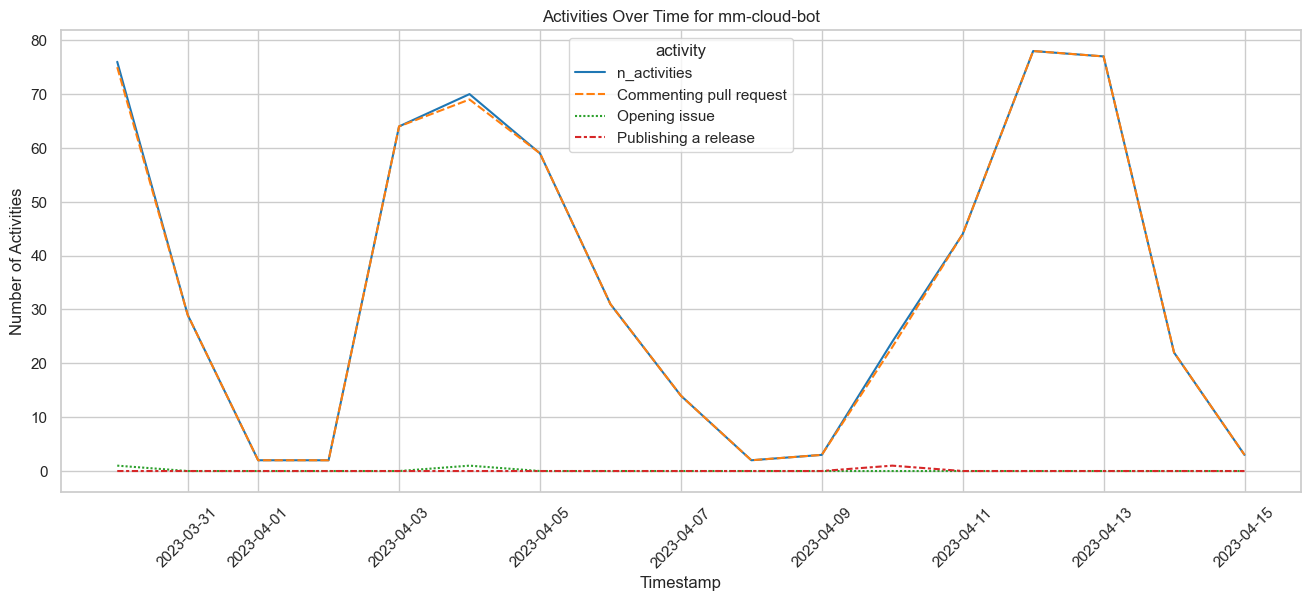

In [32]:
random_user = data['contributor'].sample().values[0]

contributor = (
    data[data['contributor'] == random_user]
    .reset_index(drop=True)[['activity', 'date']]
    .groupby([pd.Grouper(key='date', freq='D'), 'activity'])['activity']
    .count()
    .reset_index(name='n_activities')
    .set_index('date')
    .rename_axis(None)
    .pivot(columns='activity', values='n_activities')
    .fillna(0)
    .astype(int)
)
contributor.insert(0, 'n_activities', contributor.sum(axis=1))

plt.figure(figsize=(16, 6))
sns.lineplot(data=contributor, palette="tab10")
plt.xlabel('Timestamp')
plt.ylabel('Number of Activities')
plt.title('Activities Over Time for {}'.format(random_user))
plt.xticks(rotation=45)
plt.show()